# RIP.ie daily death data analysis

* http://dmnfarrell.github.io/
* https://data.gov.ie/dataset/list-of-nursing-homes-in-ireland/resource/489aad00-cad1-41d7-92bf-8b5cdd9d61ea
* https://data.gov.ie/dataset/62954fa3-1492-48af-93d1-5c9bf6a14d1e/resource/142d3b64-8f02-4ed7-bfbd-dc3e20420f3f#&r=C01885V02316&c=STATISTIC


In [46]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
import difflib, re

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', 500)
mpl.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 1

In [47]:
df = pd.read_parquet('rip_dn_scrape_final.parquet')

In [4]:
def get_season(x):
    if x.month<6:
        return '%s-%s' %(x.year-1,x.year)
    else:
        return '%s-%s' %(x.year,x.year+1)

In [5]:
def get_data(dups=False):
    
    #df = pd.read_pickle('rip_dn_scrape_processed.pkl')
    df = pd.read_parquet('rip_dn_scrape_processed.parquet')
    df=df.dropna(subset=['date'])
    if dups==False:
        df=df.drop_duplicates(['name','date','county'])
    print (len(df))    
    #df['date'] = pd.to_datetime(df.date,format='%d/%m/%Y',errors='coerce')
    df['name'] = df.name.replace('  ',' ')
    df.index=df.index.astype('int')
    df.sort_index()
    df['year'] = df.date.dt.year.astype(int)
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.dayofyear
    df['week'] = df.date.dt.isocalendar().week
    #df['week'] = df.date.dt.strftime('%W').astype('int')
    df['year-week'] = df.date.dt.strftime('%Y-W%U')
    df['season'] = df.apply(get_season,1)
    return df

df = get_data()
df = df[df.year>=2008]

524727


In [ ]:
df.dtypes

## fill missing county

In [6]:
counties = ['Limerick', 'Dublin', 'Louth', 'Donegal', 'Tipperary',
       'Wicklow', 'Mayo', 'Cavan', 'Westmeath', 'Carlow', 'Leitrim',
       'Kildare', 'Kilkenny', 'Cork', 'Meath', 'Offaly', 'Wexford',
       'Roscommon', 'Galway', 'Kerry', 'Monaghan', 'Laois', 'Sligo',
       'Clare', 'Longford', 'Waterford']

def fill_county(x):    
    c=x.county
    if c not in ['',None,np.nan]:
        return c
    a = x.address.split()[-1]
    if a in counties:
        return a    
    #print(c,a)
    return ''

df.county.value_counts()
df['county']=df.apply(fill_county,1)

## remove emigrant deaths

In [7]:
cities=['England','UK','USA','London','Manchester','Liverpool','Leeds','Birmingham','Glasgow','Edinburgh',
        'New York','Boston','Pittsburgh','Philadelphia','Sydney','Melbourne','Perth','New Jersey','Melbourne',
        'Worcester','Ohio','Cleveland','England','Hull','Lancashire']
search='|'.join(cities)
print (len(df))
df = df[~df.address.str.contains(r"\b(%s)\b" %search)]
print (len(df))

492649


/tmp/ipykernel_1986453/1833324812.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df.address.str.contains(r"\b(%s)\b" %search)]


483593


In [28]:
search1='UK'
search2='Formerly of'
#df[df.notice.str.contains(r"\b(%s)\b" %(search1))]
#df[df.notice.str.contains(r"\b((?=.*%s)(?=.*%s))\b" %(search1,search2))]

## get male/female

In [8]:
female=list(pd.read_csv('female_names.csv')['name'].str.lower())
male=list(pd.read_csv('male_names.csv')['name'].str.lower())
u=[]
def check_name(x):
    """try to detect sex"""
    
    notice=str(x.notice).lower()
    mr=['son of','husband of']
    for n in mr:
        if n in notice:
            return 'M'
    fr=['wife of','daughter of']
    for n in fr:
        if n in notice:
            return 'F' 
    if 'convent' in notice or 'wife of' in notice:
        return 'F'
    kwds = ['loving','home','residence','family','parents','heartbroken',
            'son','daughter','sister','brother','remains','wife','partner']
    for n in kwds:
        if 'his '+n in notice:
            return 'M'
        elif 'her '+n in notice:
            return 'F'
    name=x['name']
    if type(name) is float:
        return
    if 'née' in name:
        return 'F'
    #print (x)
    s = name.split()
    s = [i.strip("()").strip(',').lower() for i in s]
    #print (s)
    for n in s:
        if len(n)<=1:
            continue
        if n in female:
            return 'F'
        elif n in male:
            return 'M'            
    #print (s)
    u.extend(s)
    return 'U'

df['sex'] = df.apply(check_name,1)
df.sex.value_counts()

sex
M    246148
F    236222
U      1223
Name: count, dtype: int64

In [9]:
df[df.sex=='U'].to_csv('unknown.csv')

## nursing homes

crude method to to find notices referring to nursing homes. may take several minutes

In [10]:
nhomes = pd.read_csv('nursing_homes.csv')
search = '|'.join(nhomes.name)
ss = r"\b(%s)\b" %search
#print (ss)

def find_nhome(x):
    if type(x.notice) is not str:
        return
    notice = x.notice.replace(',',' ')
    f =  re.findall(ss,notice)
    if len(f)>0:
        return f[0][0]    
    kwds = ['nursing home','care home','residential care']
    for k in kwds:
        if k in notice.lower():
            return 'unknown'
    
import time
st=time.time()
z=df.sample(600,random_state=4)
z['home'] = z.apply(lambda x: find_nhome(x),1)
#print (x.home)
print (len(z[~z.home.isnull()]))
print(time.time()-st)

104
0.29428553581237793


In [ ]:
z[z.home=='unknown']

In [11]:
df['home'] = df.apply(lambda x: find_nhome(x),1)

In [12]:
#df.to_pickle('rip_dn_scrape_final.pkl')
df.to_parquet('rip_dn_scrape_final.parquet')

## check subset

In [ ]:
df[(df.year==2023) & (df.week==14)][['id','name','date','year','week']]

## <div style='background :lightblue' > Post processing </div>

# Plots

In [ ]:
sub=df[~df.home.isnull()]
X=pd.pivot_table(sub, index='month',columns='year',values='home',aggfunc='size')
f,ax=plt.subplots(1,2,figsize=(14,7))
axs=ax.flat
g=sns.heatmap(X.iloc[:,4:],cmap='coolwarm',ax=axs[0]) #annot=True,annot_kws={'fontsize':8}
f.suptitle('RIP.ie notices mentioning nursing homes, per month')
axs[0].set_title('total per month')
#print (X)
sub[(sub.date<'2023-11-30')].groupby('year').size().plot(ax=axs[1])
axs[1].set_title('trend yearly (likely reporting bias)')
plt.tight_layout()
f.savefig('nursing_home_heatmap.png')

<Axes: xlabel='year'>

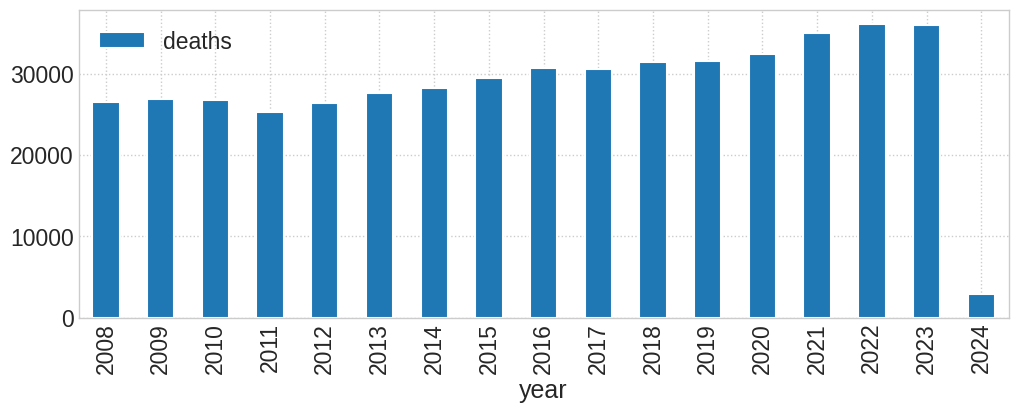

In [14]:
d=pd.DataFrame(df.groupby(['year']).size(),columns=['deaths']).reset_index()
#print (d)
#sns.catplot(data=d,x='year',y='deaths',kind='bar',estimator=np.sum,aspect=3.0)
d.plot(x='year',kind='bar',figsize=(12,4))

In [ ]:
d = df.groupby('season').agg({'name':np.size})
d = d[6:]
d.plot(kind='bar',figsize=(12,4))

In [ ]:
sub=df[df.sex!='U']
g=sub.groupby(['year','month','sex']).agg({'name':np.size}).reset_index()
g = g[(g.year>2016) & (g.year<=2023)]
#print (g)
sns.catplot(data=g,x='sex',y='name',hue='year',kind='box',aspect=3.0)
plt.title('Average monthly deaths by sex')
#plt.savefig('ireland_deaths_ripie_bysex.png',dpi=150)

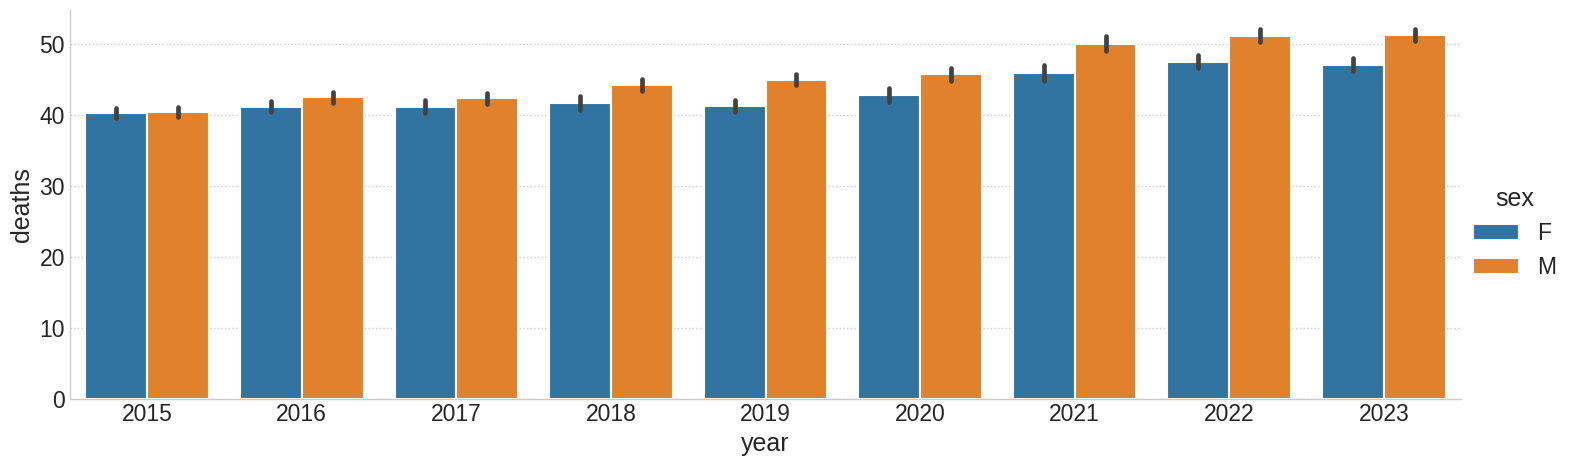

In [15]:
sub=df[df.sex!='U']
#sub=df[~df.home.isnull()]
d=pd.DataFrame(sub.groupby(['date','sex','year']).size(),columns=['deaths']).reset_index()
#d.to_csv('rip_est_deaths_daily.csv',index=False)
d = d[(d.year>2014) & (d.year<=2023)]
sns.catplot(data=d,x='year',y='deaths',hue='sex',kind='bar',aspect=3.0) 

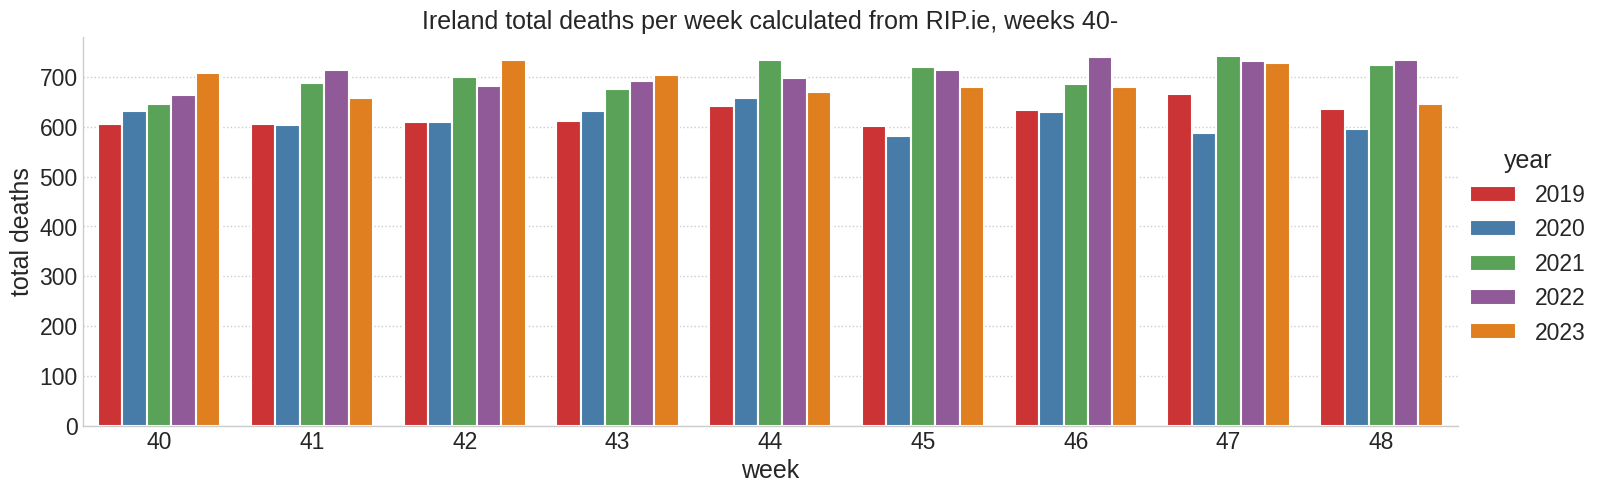

In [16]:
start=40
g=df.groupby(['year','week']).agg({'name':np.size}).reset_index()
g=g[(g.week>=start) & (g.week<=48)]
g = g[(g.year>2018) & (g.year<=2023)]
#print (g)
sns.catplot(data=g,x='week',y='name',hue='year',kind='bar',aspect=3.0, palette='Set1')
plt.ylabel('total deaths')
plt.title('Ireland total deaths per week calculated from RIP.ie, weeks %s-' %start)
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

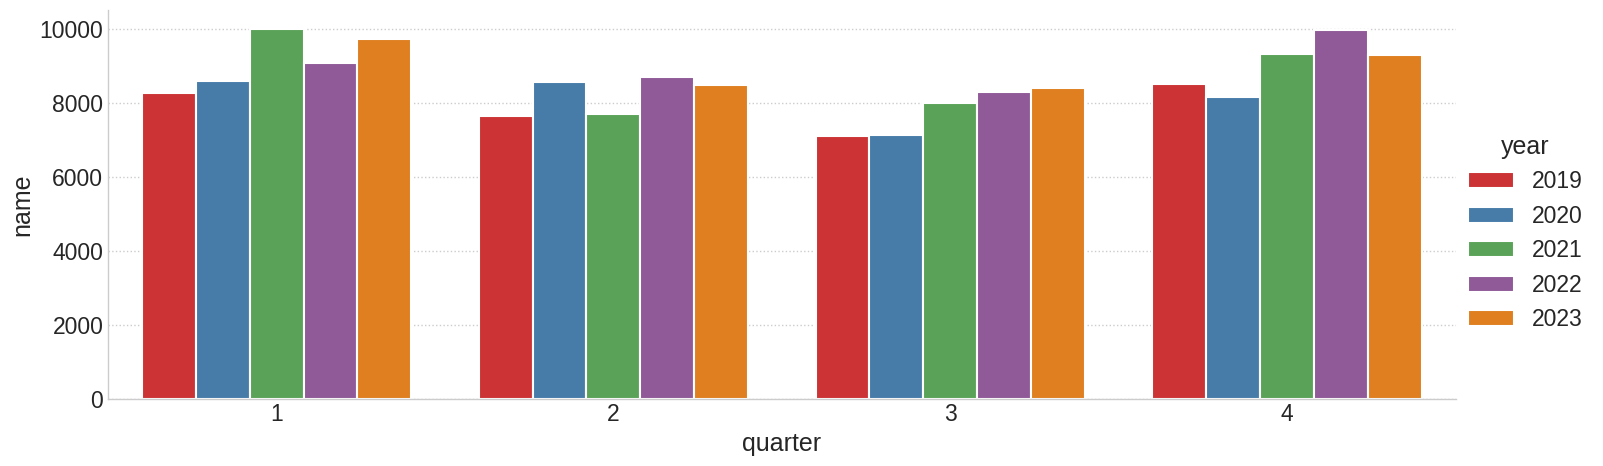

In [17]:
df['quarter'] = df.date.dt.quarter
g=df.groupby(['year','quarter']).agg({'name':np.size}).reset_index()
g = g[(g.year>2018) & (g.year<2024)]
sns.catplot(data=g,x='quarter',y='name',hue='year',kind='bar',aspect=3.0, palette='Set1')
plt.savefig('ireland_deaths_ripie_bymonth_v2.png',dpi=150)

## weeks with most deaths

In [ ]:
sub=df#[df.S==True]
g=sub.groupby(['year','week']).agg({'name':np.size}).reset_index()
g = g[(g.year>2019)]
g=g.sort_values('name')[-10:]
g['wk-yr'] = g.apply(lambda x: str(x.week)+'-'+str(x.year),1)
print (g)
g.plot(x='wk-yr',y='name',kind='barh',legend=False)
plt.title('most deaths in a week')

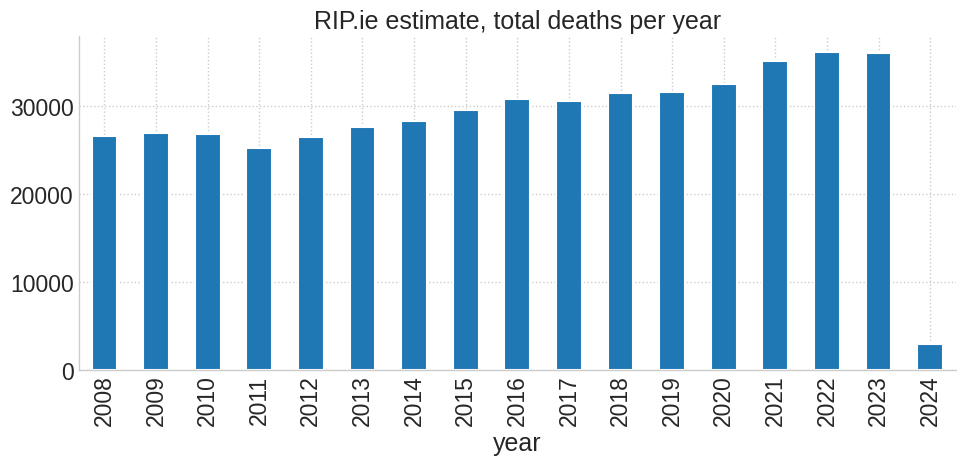

In [62]:
#x=df[(df.month<=12) & (df.month>5)]
totals = df.groupby('year').agg('size')
#print (totals)
ax=totals.plot(kind='bar',grid=True,figsize=(10,5))
plt.title('RIP.ie estimate, total deaths per year')
sns.despine()
plt.tight_layout()
#plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)

## registered deaths

https://data.cso.ie/table/VSQ01

In [20]:
pop = pd.read_csv('ireland_population.csv')
gro = pd.read_csv('gro_deaths_yearly.csv')
#pop.plot(x='year')

/tmp/ipykernel_1986453/2238269933.py:2: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  cso['year'] = cso.quarter.apply(lambda x: x[:4],1).astype(int)
/tmp/ipykernel_1986453/2238269933.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cso_yearly = cso.groupby('year').agg({'deaths':sum}).reset_index()[:-1]


Text(0.5, 1.0, 'ireland registered mortality 1960-')

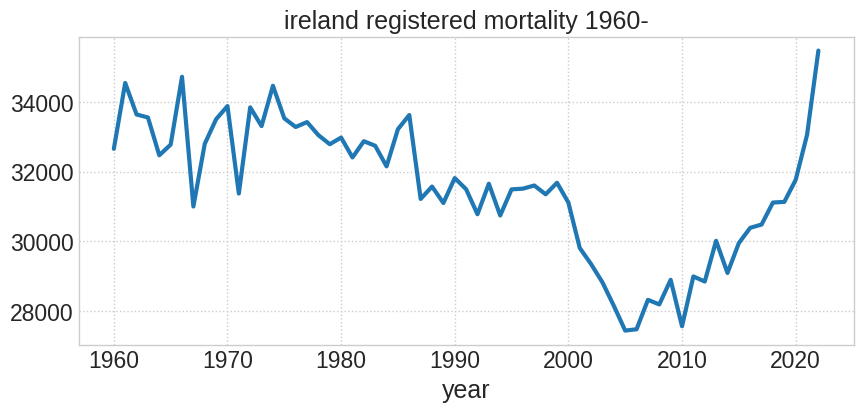

In [21]:
cso = pd.read_csv('cso_deaths.csv')
cso['year'] = cso.quarter.apply(lambda x: x[:4],1).astype(int)
cso_yearly = cso.groupby('year').agg({'deaths':sum}).reset_index()[:-1]
cso_yearly=cso_yearly.rename(columns={'deaths':'cso'})
cso_yearly.plot(x='year',y='cso',lw=3,legend=False,figsize=(10,4))
plt.title('ireland registered mortality 1960-')

## compare gro/cso to rip deaths

Text(0.5, 1.0, 'Registered deaths vs. RIP.ie estimates')

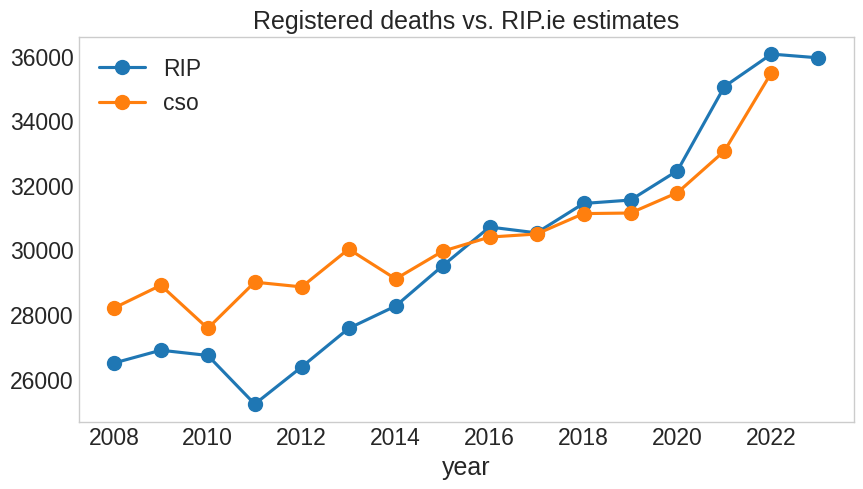

In [22]:
d=pd.DataFrame(totals,columns=['deaths']).reset_index()
d=d.rename(columns={'deaths':'RIP'})
d=pop.merge(d,on='year')
d=d.sort_values('year')
d['deathsper1000'] = d.RIP/d['pop']*1e3
d=d.merge(gro,on='year',how='left')
d=d.merge(cso_yearly,on='year',how='left')
d['diff'] = d.RIP-d.cso
#print (d)

d.plot(x='year',y=['RIP','cso'],marker='o',ms=10,grid=False,figsize=(10,5))
plt.title('Registered deaths vs. RIP.ie estimates')

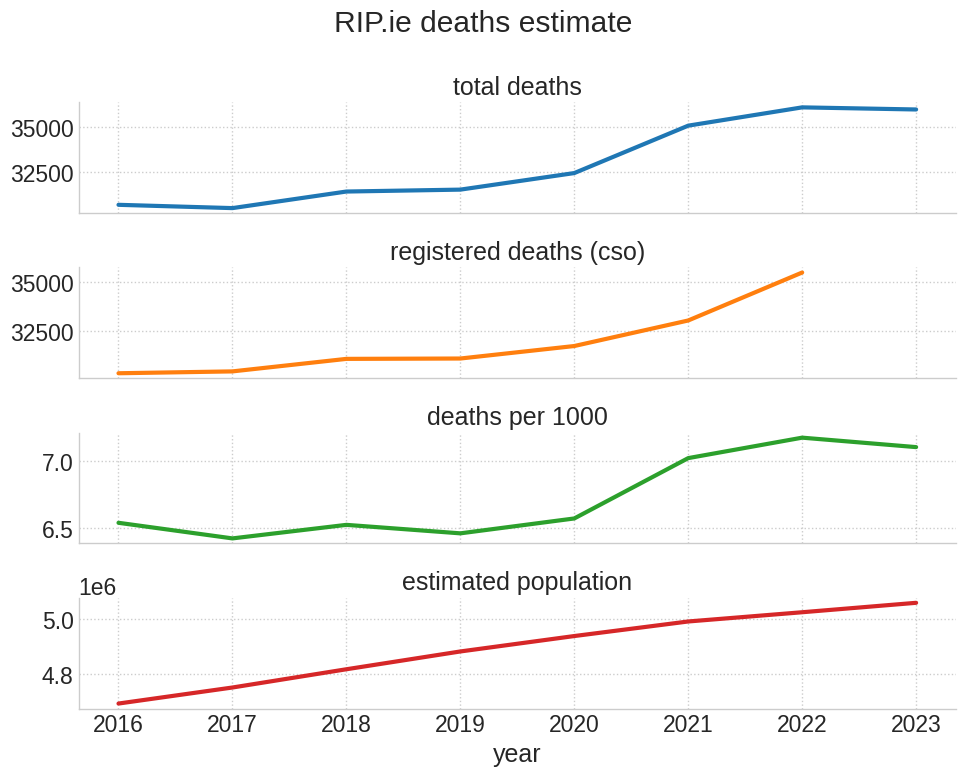

In [23]:
axs = d[8:].plot(x='year',y=['RIP','cso','deathsper1000','pop'],kind='line',lw=3,
                 subplots=True,grid=True,legend=False,figsize=(10,8))
axs[0].set_title('total deaths')
axs[1].set_title('registered deaths (cso)')
axs[2].set_title('deaths per 1000')
axs[3].set_title('estimated population')
plt.suptitle('RIP.ie deaths estimate')
sns.despine()
plt.tight_layout()

Text(0.5, 1.0, 'RIP.ie mortality vs CSO 2016 projections')

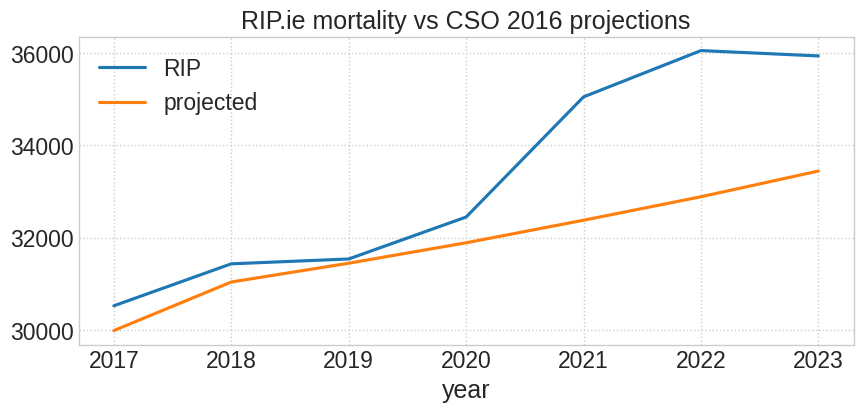

In [24]:
proj = pd.read_csv('cso_projected_annual_deaths.csv')
proj = proj[proj.method=='Method - M1F1']
x=d.merge(proj,on='year',how='inner')
x.plot(x='year',y=['RIP','projected'],figsize=(10,4))
plt.title('RIP.ie mortality vs CSO 2016 projections')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,6))
d.plot('cso','deaths',kind='scatter',c=d.year,s=100,cmap='coolwarm',ax=ax)
ax.set_ylabel('rip.ie est')
ax.plot([24000, 34000], [25000, 34000], ls='--')
ax.set_xlim(24000,34000)
ax.set_ylim(24000,34000)
plt.tight_layout()
fig.savefig('ireland_deaths_gro_vs_ripie2.png',dpi=120)

In [ ]:
byw = pd.pivot_table(df, index='week',columns='year',values='name',aggfunc='size')
byw['5 yr average'] = byw.iloc[:,8:-1].mean(1)
x=byw.iloc[23:52,13:]
#print (x)
x.plot(kind='bar',width=.8,figsize=(20,6))
#x.T.boxplot(figsize=(18,6))
plt.legend(loc=4,ncol=5,framealpha=0.9,fontsize=20)
plt.suptitle('RIP.ie deaths per week')
sns.despine()
#plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

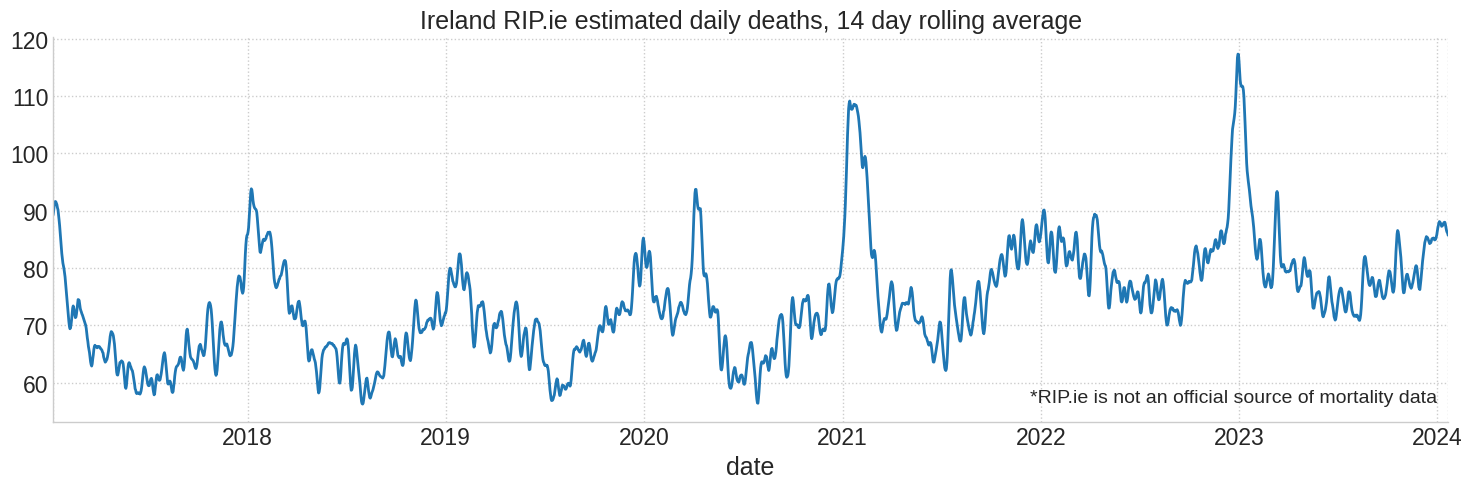

In [25]:
sub = df[df.home.isnull()] 
sub = sub[sub.year>=2017]
x = sub.groupby('date').size()
r21 = x.rolling(14,win_type='hamming',center=True).mean().dropna()
yr=x.resample("Q",convention='end').agg(["sum"]).reset_index()[:-1]
ax=r21.plot(x='date',y='deaths',lw=2,figsize=(18,5),label='14 day mean')#,grid=True)#
#for y in range(2016,2023):
#    ax.vlines(pd.to_datetime('%s-12-31' %y),60,110,color='r',ls=':',lw=1.2)#,transform=ax.get_xaxis_transform())
plt.title('Ireland RIP.ie estimated daily deaths, 14 day rolling average')
plt.text(0.7,0.05,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
sns.despine()

## smoothed trends per year

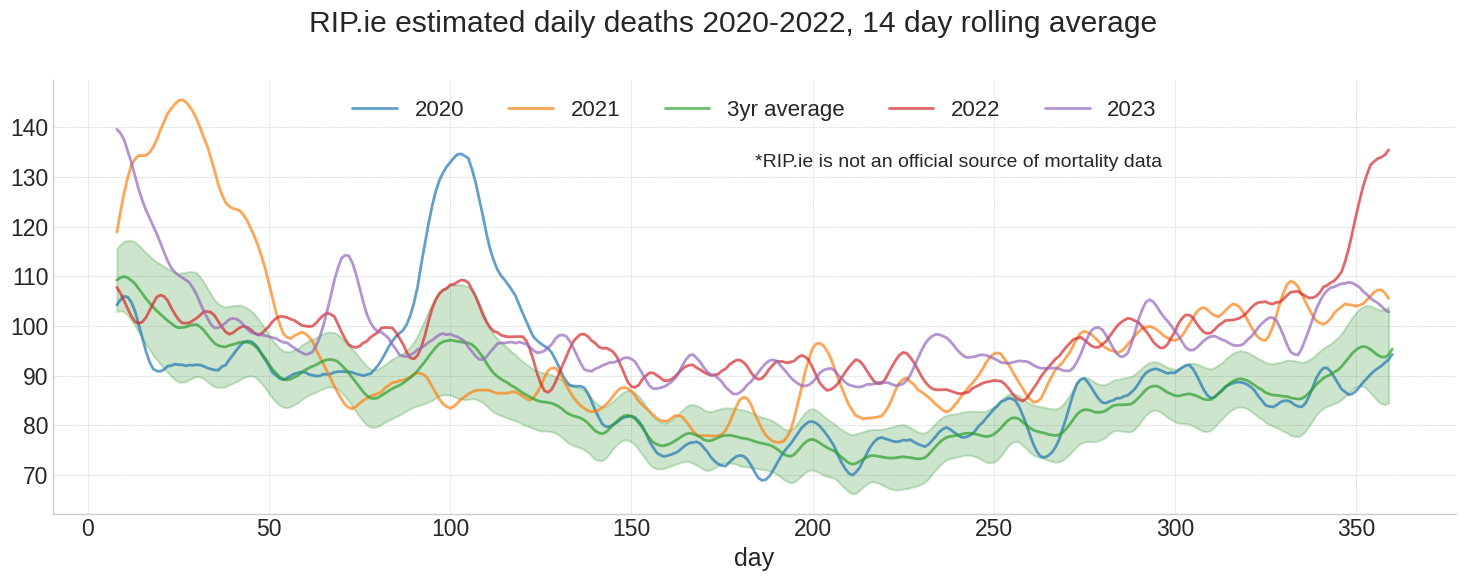

In [20]:
def plot_average_trend(df, title=''):
    
    byday = pd.pivot_table(df, index='day',columns='year',values='name',aggfunc='size')
    #print (byday.iloc[:,9:-4])
    byday['3yr average'] = byday.iloc[:,9:-4].mean(1)
    byday['sd'] = byday.iloc[:,9:-3].std(1)
    x = byday[[2020,2021,'3yr average',2022,2023]]
    #x = byday[['2020-2021','2021-2022','3yr average']]
    #x = x.loc[:50]   
    #x.loc[364:,2021] = np.nan
    win=14
    meanday = x.rolling(window=win,win_type='hamming',center=True).mean()
    sd = byday['sd'].rolling(window=win,win_type='hamming',center=True).mean()
    ax=meanday.plot(figsize=(15,6),lw=2,alpha=0.7)
    ave=meanday['3yr average']
    
    ax.fill_between(ave.index, ave-(sd/2), ave+(sd/2), color='green', alpha=0.2)
    ax.grid(linestyle='--',linewidth=.4)
    plt.legend(loc=9,ncol=5,fontsize=16)
    sns.despine()
    plt.suptitle('%s, %s day rolling average' %(title,win))
    plt.tight_layout()
    plt.text(0.5,0.8,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
    
plot_average_trend(df,'RIP.ie estimated daily deaths 2020-2022')
plt.savefig('ireland_deaths_ripie_compared_mean_v3.png',dpi=150)

In [ ]:
s=df[df.home.isnull()]   
plot_average_trend(s,'RIP.ie deaths not mentioning nursing homes')
plt.savefig('ireland_deaths_ripie_compared_mean_nursing_homes.png',dpi=150)

In [ ]:
s=df[df.sex=='M']   
plot_average_trend(s,'RIP.ie deaths, Male')

## excess deaths

year   2016   2017   2018   2019   2020
week                                   
1     368.0  402.0  448.0  375.0  255.0
2     338.0  435.0  444.0  344.0  379.0
3     331.0  409.0  439.0  317.0  332.0
4     331.0  382.0  348.0  339.0  321.0


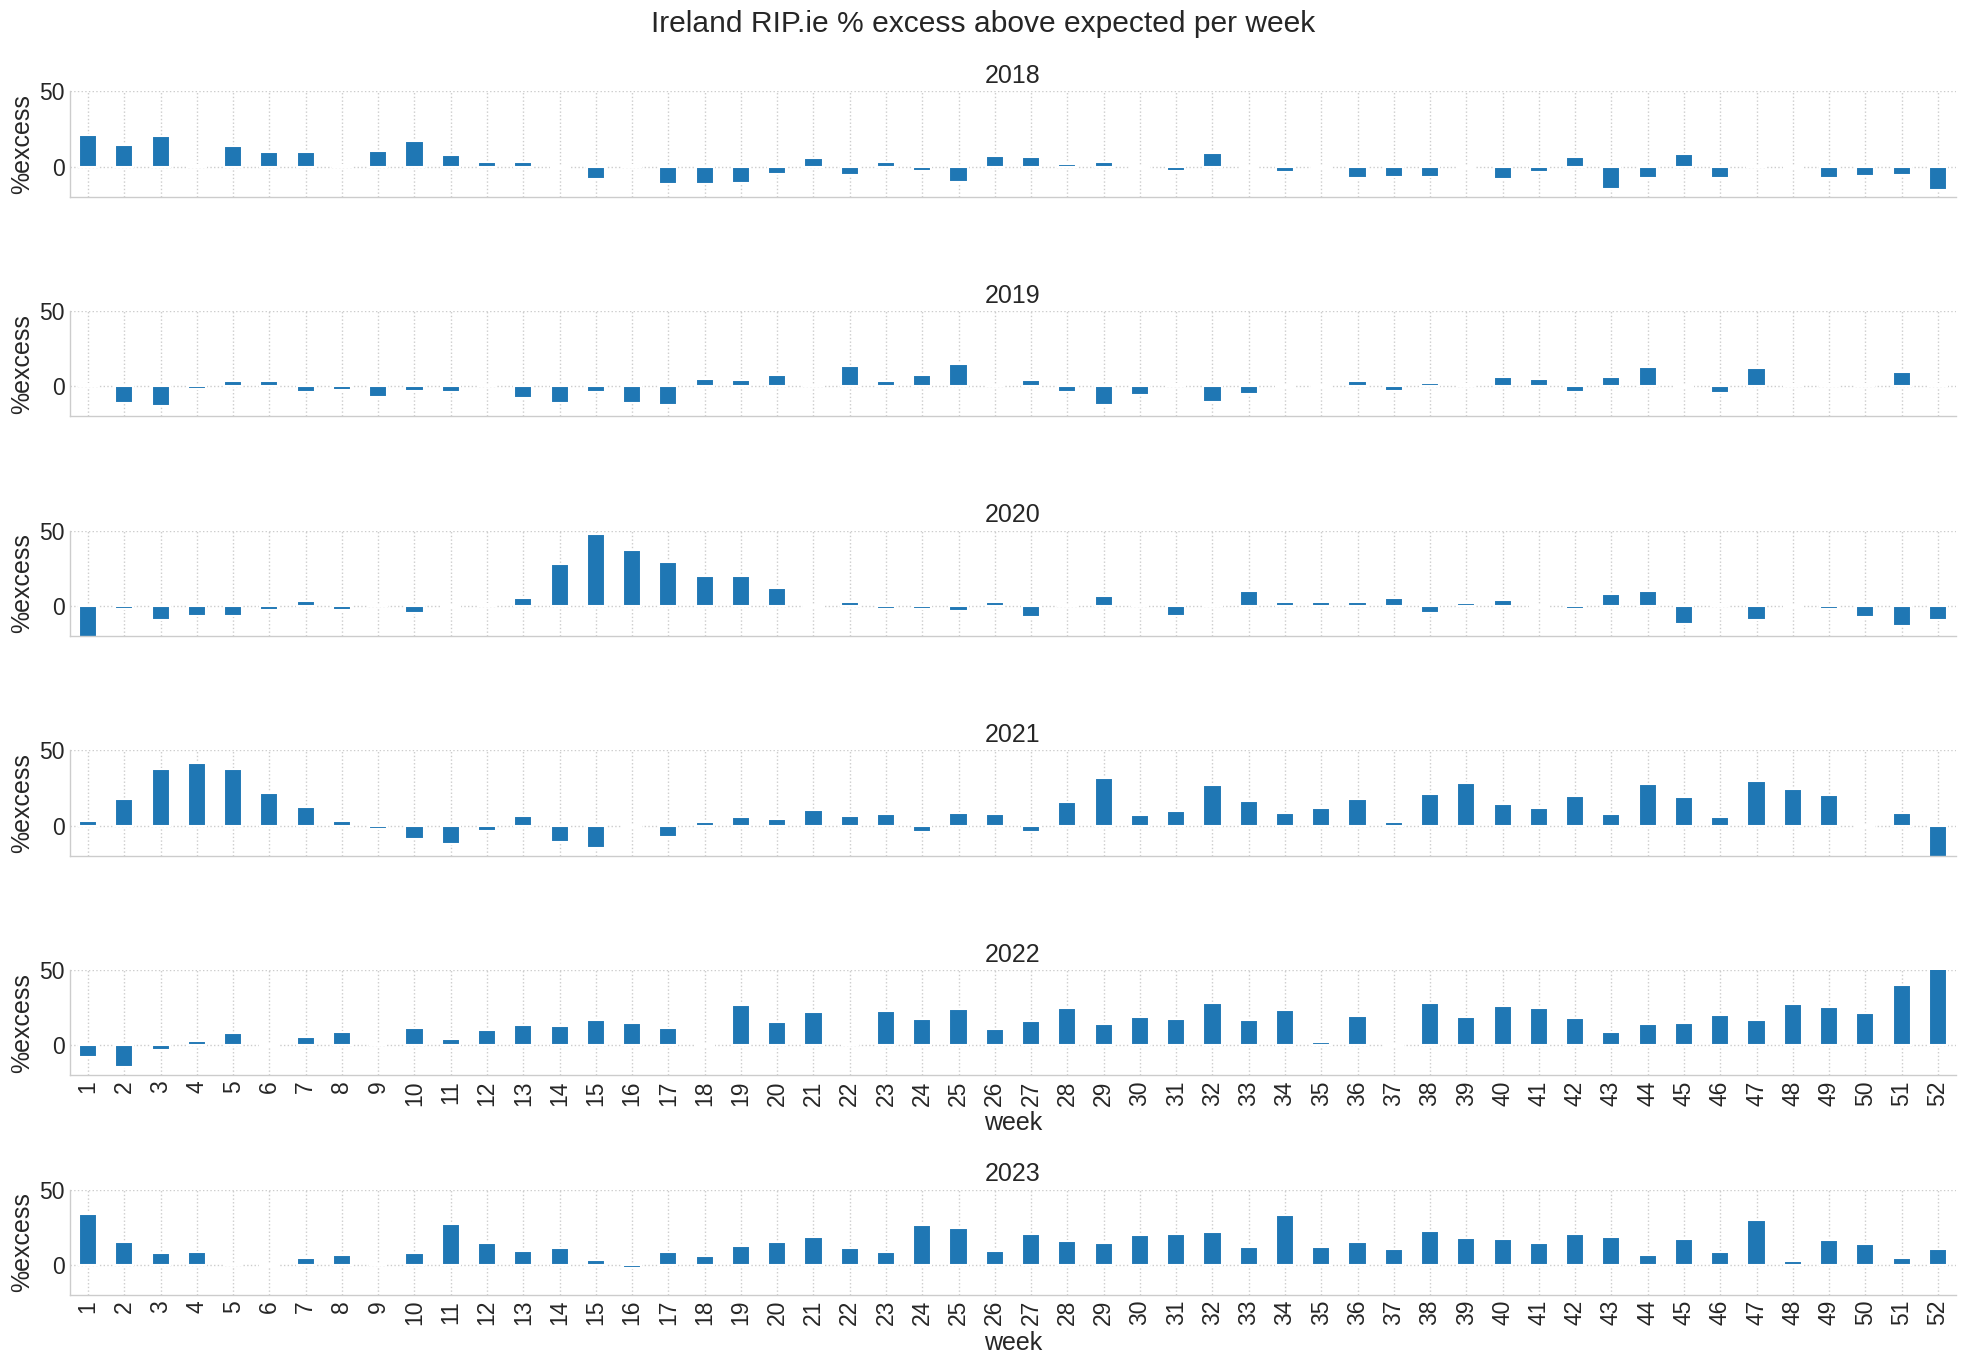

In [48]:
fig, ax = plt.subplots(6,1,figsize=(20,14))
axs=ax.flat
sub = df[df.sex=='F']   
sub = sub[(sub.date<'2023-12-31')]
g = sub.groupby(['year','week']).agg({'name':np.size}).reset_index()
p = pd.pivot_table(g,index='week',columns='year',values='name',aggfunc='sum')
print (p.iloc[:,8:13][:4])
#get mean of selected years
p['mean'] = p.iloc[:,8:13].mean(1)
p = p.iloc[:-1]
#p.loc[52,2022] = None
i=0
exc = p.sub(p['mean'], axis=0)
for year in [2018,2019,2020,2021,2022,2023]:
    ax=axs[i]
    #p['excess'] = p[year]-p['mean']
    p['excess'] = (p[year]-p['mean'])/p['mean']*100
    p.plot(y=['excess'],kind='bar',stacked=True,legend=False,ax=ax)
    ax.set_ylabel('%excess')
    ax.set_title(year)
    ax.set_ylim(-20,50)
    if i<4:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    i+=1
fig.suptitle('Ireland RIP.ie % excess above expected per week')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_weekly_excess_percentage.png',dpi=130)

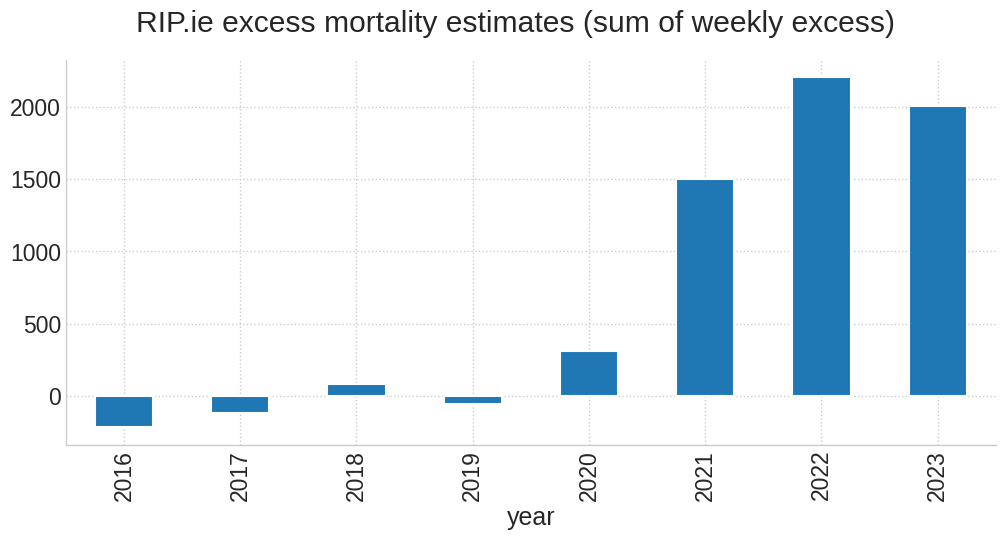

In [49]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
x=exc.sum()[8:-1]
x.plot(kind='bar',ax=ax)
mean = x.mean()
#print (x)
#ax.hlines(mean,mean,-1,color='r')
fig.suptitle('RIP.ie excess mortality estimates (sum of weekly excess)')
sns.despine()

## fit models to data

In [50]:
#sub = df
sub = df[df.home.isnull()]
sub = sub[sub.year>=2014]
x = sub.groupby('date').size()
r14 = x.rolling(14,win_type='hamming',center=True).mean().dropna()
#r7 = x.rolling(7,win_type='hamming',center=True).mean()

#baseline deaths from summer periods only
summer = sub[(sub.month>5) & (sub.month<9)& (sub.year<=2020)]
y = summer.groupby('date').size()
base = y.rolling(14,win_type='hamming',center=True).mean().dropna()

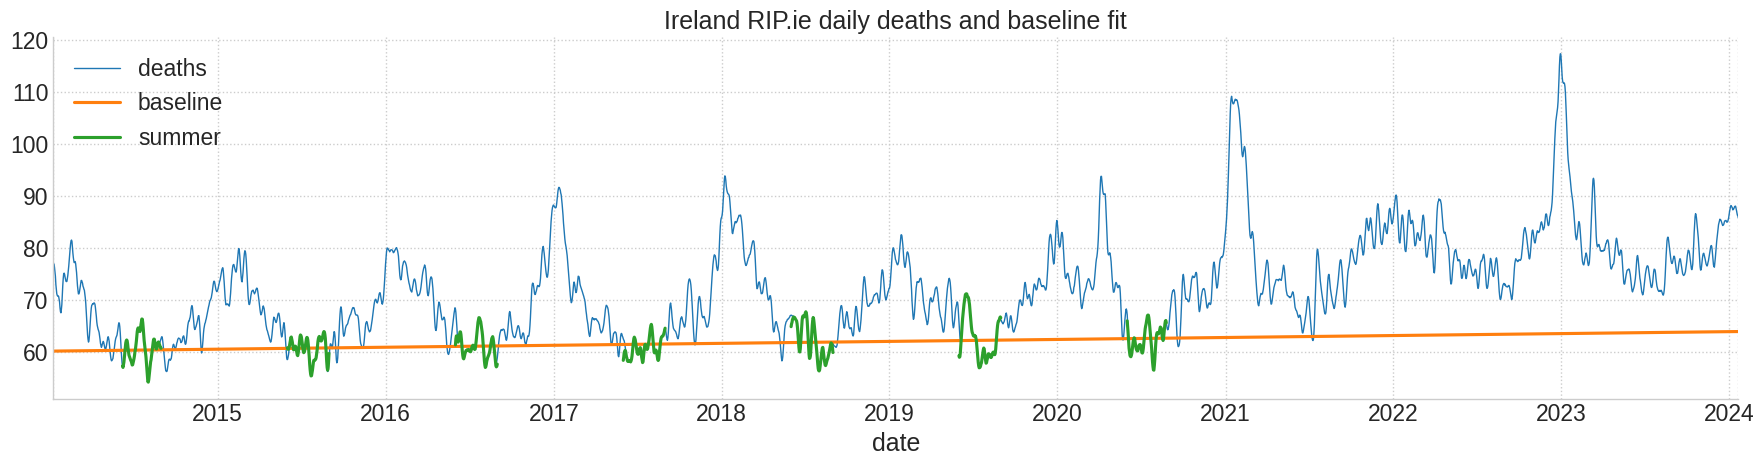

In [51]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

#rdf=pd.DataFrame([r14,base],columns=['deaths','baseline']).reset_index()
rdf = pd.concat([r14,base],axis=1)
rdf.columns=['deaths','summer']
rdf=rdf.reset_index()
rdf['ind'] = rdf.index.astype(float)+1
rdf['year'] = rdf.date.dt.year
rdf['month'] = rdf.date.dt.month
rdf['day'] = rdf.date.dt.dayofyear
#rdf['rolling'] = rdf.deaths.rolling(window=21,win_type='hamming',center=True).mean()
rdf['season'] = rdf.apply(get_season,1)
#print (rdf)
model = smf.ols(formula='summer ~ ind', data=rdf).fit()

rdf['baseline'] = model.predict(rdf.ind)
rdf['excess'] = rdf.deaths - rdf.baseline

ax=rdf.plot(x='date',y='deaths',lw=1,figsize=(18,5))
rdf.plot(x='date',y='baseline',ax=ax)
rdf.plot(x='date',y='summer',ax=ax)

#rdf.plot(x='date',y='rolling',ax=ax)
plt.title('Ireland RIP.ie daily deaths and baseline fit')
sns.despine()
plt.tight_layout()
#plt.savefig('ireland_deaths_baseline_fit.png',dpi=130)

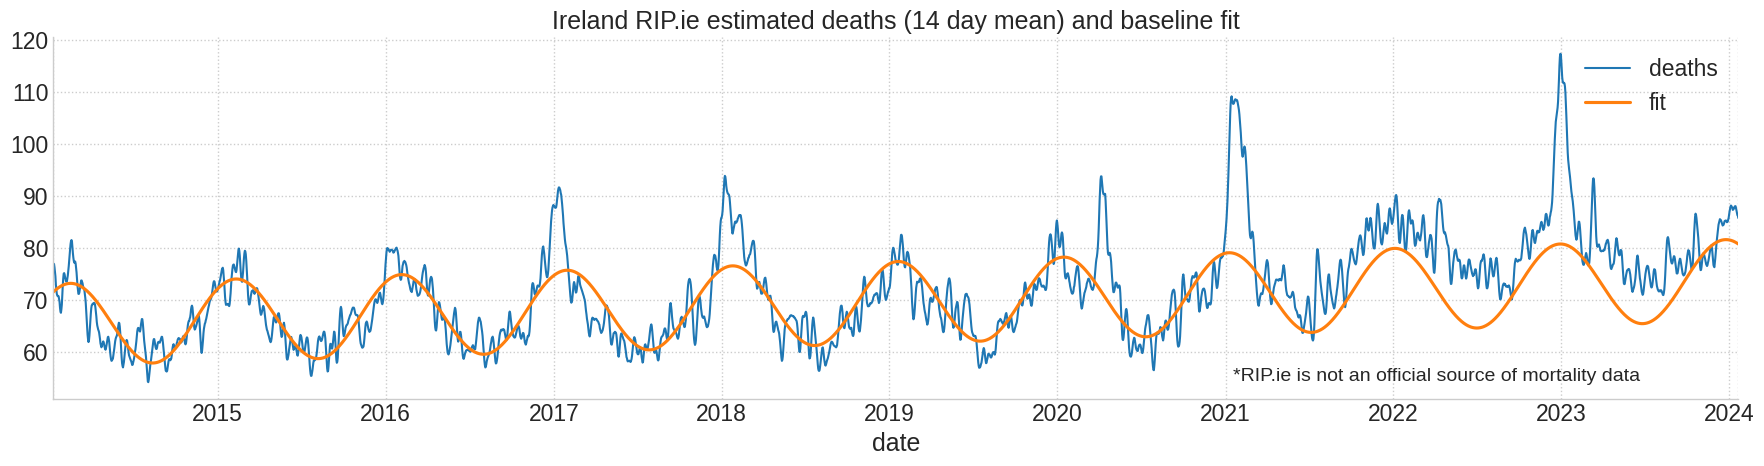

In [52]:
#import math
pre = rdf[rdf.year<2021].copy()

model2 = smf.ols(formula='deaths ~ ind + np.cos(np.radians(ind)) + np.sin(np.radians(ind))', data=pre).fit()
#model2 = smf.ols(formula='summer ~ ind + np.vander(ind, 2, increasing=True) + 1', data=pre).fit()  
#print(model2.summary())
#model2.resid.plot(kind='hist', bins=30)

rdf['fit'] = model2.predict(rdf.ind)
rdf['excess2'] = rdf.deaths - rdf.fit

ax=rdf.plot(x='date',y='deaths',lw=1.5,figsize=(18,5))
rdf.plot(x='date',y='fit',ax=ax)

#for y in range(2014,2023):
    #ax.vlines(pd.to_datetime('%s-12-31' %y),60,125,color='r',ls=':',lw=1.2)
plt.title('Ireland RIP.ie estimated deaths (14 day mean) and baseline fit')
plt.text(0.7,0.05,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
sns.despine()
plt.tight_layout()
#plt.savefig('ireland_deaths_periodic_fit.png',dpi=130)

/tmp/ipykernel_1986453/2433111408.py:6: FutureWarning: The provided callable <function sum at 0x7f615a9dd1b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ex = rdf.groupby([c]).agg({'excess2':np.sum})[1:]
/tmp/ipykernel_1986453/2433111408.py:6: FutureWarning: The provided callable <function sum at 0x7f615a9dd1b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ex = rdf.groupby([c]).agg({'excess2':np.sum})[1:]


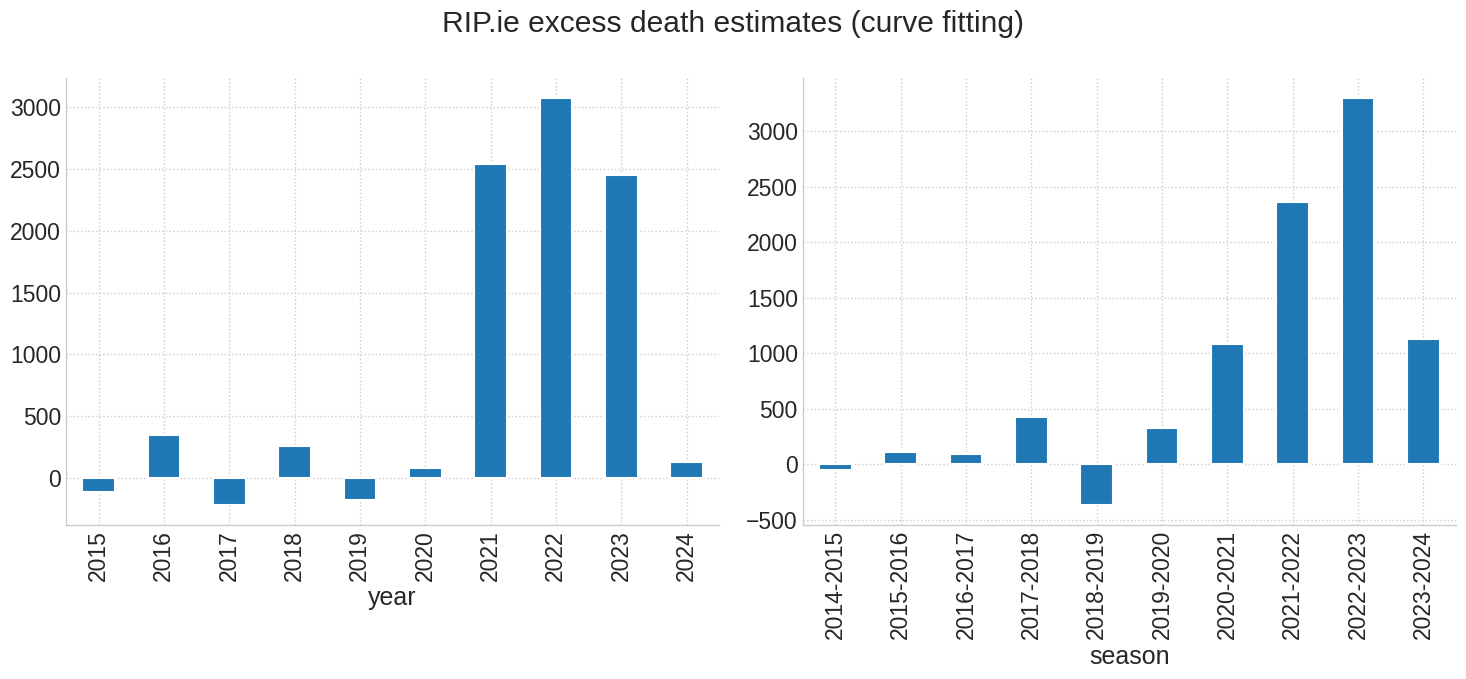

In [58]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
axs=ax.flat
i=0
for c in ['year','season']:
    ax=axs[i]
    ex = rdf.groupby([c]).agg({'excess2':np.sum})[1:]   
    ex.plot(kind='bar',legend=False,ax=ax)
    mean = ex[:-3].mean()
    std = ex[:-3].std()
    #ax.hlines(mean,mean,-1,color='r')
    i+=1
#ax.axhspan(mean-std,mean+std, alpha=0.5, color='red')
fig.suptitle('RIP.ie excess death estimates (curve fitting)')
plt.tight_layout()
sns.despine()

In [77]:
#total excess for period
ex = rdf.groupby(['year']).agg({'excess':np.sum,'excess2':np.sum})[1:]
ex['total'] = totals
ex['percent'] = ex.excess2/ex.total*100

print (ex.iloc[2:,1:3])
print (ex[6:].sum())

          excess2  total
year                    
2017  -218.165521  30520
2018   260.210871  31430
2019  -175.602321  31535
2020    79.433709  32444
2021  2540.417984  35048
2022  3074.250149  36052
2023  2453.292511  35936
2024   128.702289   2903
excess      18681.265896
excess2      8196.662933
total      109939.000000
percent        27.035925
dtype: float64


/tmp/ipykernel_1986453/2885408005.py:2: FutureWarning: The provided callable <function sum at 0x7f615a9dd1b0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ex = rdf.groupby(['year']).agg({'excess':np.sum,'excess2':np.sum})[1:]


## monthly CSO/RIP combined to see how well it fits

In [ ]:
comb = pd.read_csv('cso_rip_combined.csv')[:80]
comb['month'] = pd.to_datetime(comb.Month, format='%Y %B')
comb['ind'] = comb.index
model2 = smf.ols(formula='deaths ~ ind + np.cos(np.radians(ind)) + np.sin(np.radians(ind))',
                 data=comb, start_params={'intercept':65.17,'ind':0.0023}).fit()
#print(model2.summary())
comb['fit'] = model2.predict(comb.ind)
ax=comb.plot(x='month',y='deaths',marker='o',ms=2,lw=1,figsize=(12,3))
comb.plot(x='month',y='fit',ax=ax)

## GRO compare

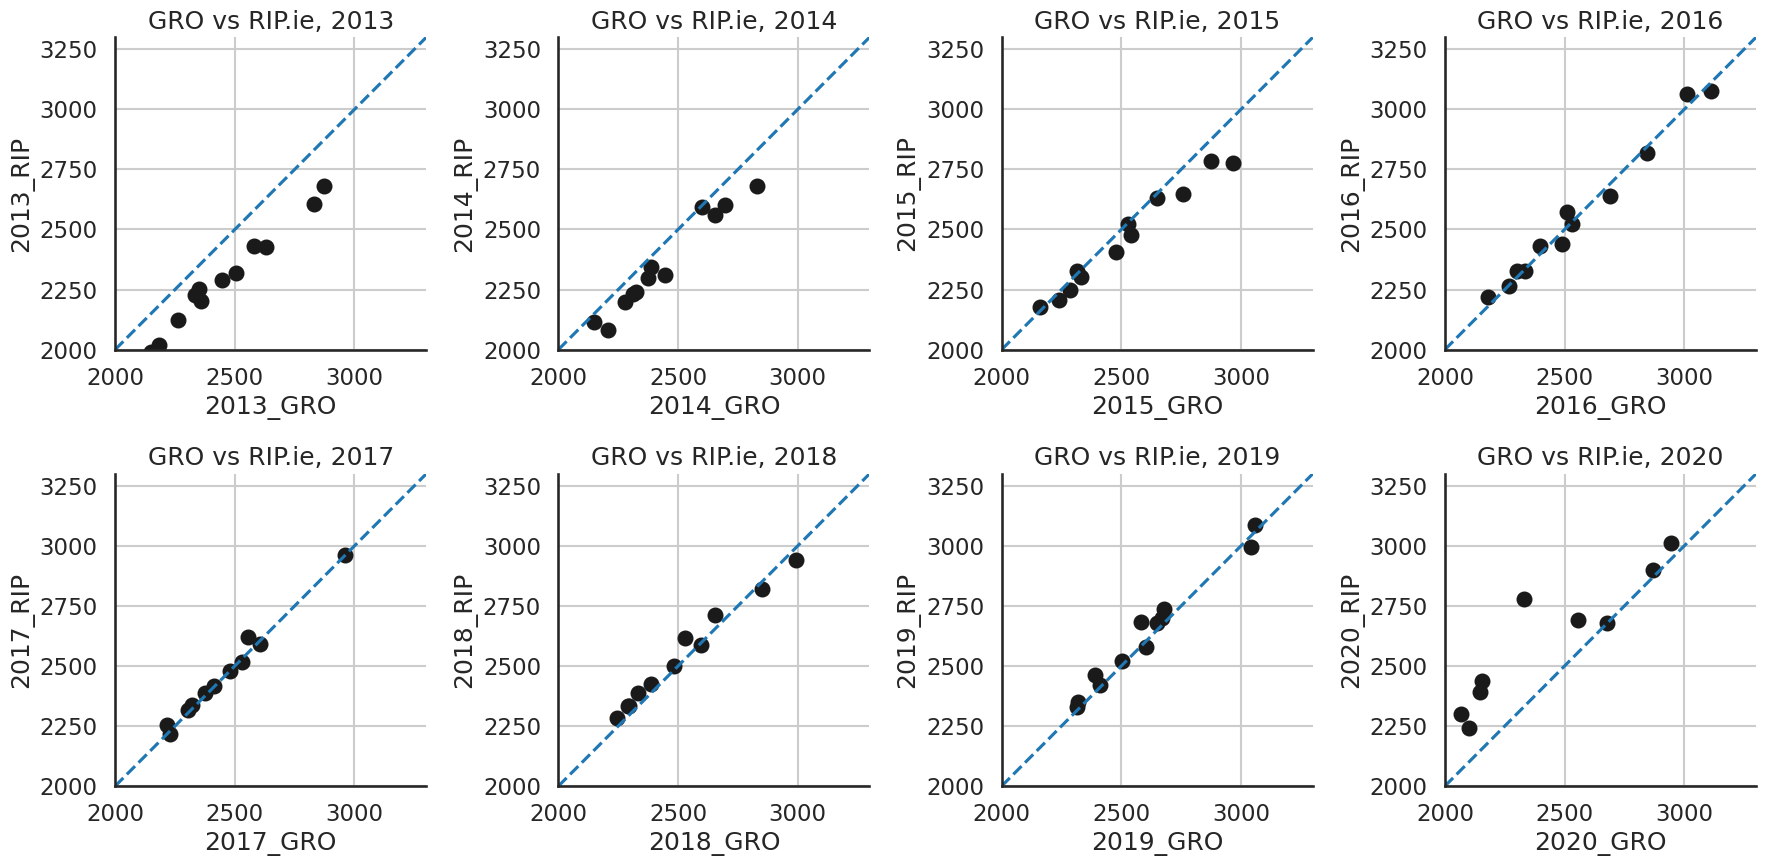

In [29]:
gro = pd.read_csv('gro_deaths.csv')
bymonth = pd.pivot_table(df, index='month',columns='year',values='name',aggfunc='size')
a=bymonth.reset_index()
a.columns=[str(i) for i in a.columns]
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#print (b)
f,axs=plt.subplots(2,4,figsize=(18,9))
axs=axs.flat
i=0
for y in range(2013,2021):
    ax=axs[i]
    b.plot(x='%s_GRO' %y,y='%s_RIP' %y,c='0.1',s=100,kind='scatter',grid=True,ax=ax)
    ax.plot([2000, 3300], [2000, 3300], ls='--')
    ax.set_xlim(2000,3300)
    ax.set_ylim(2000,3300)
    ax.set_title('GRO vs RIP.ie, %s' %y)
    i+=1
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_gro_vs_ripie.png',dpi=150)

## compare eurostat data

Text(0.5, 1.0, 'mean monthly percentage excess mortality (eurostat)')

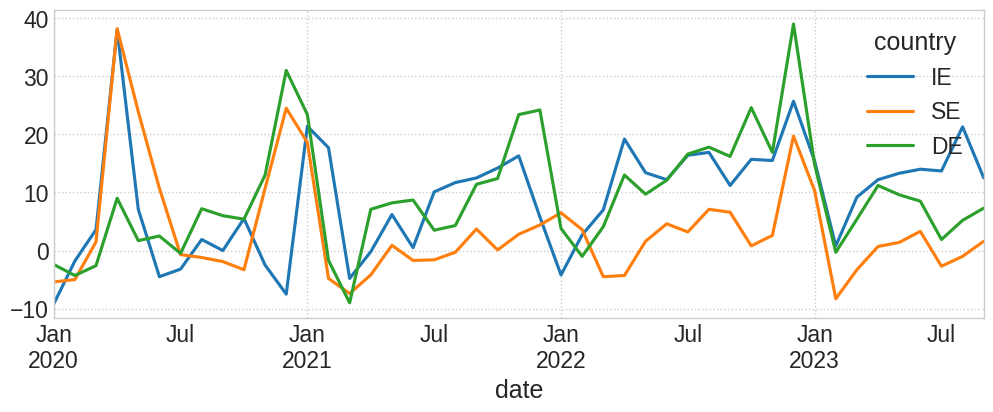

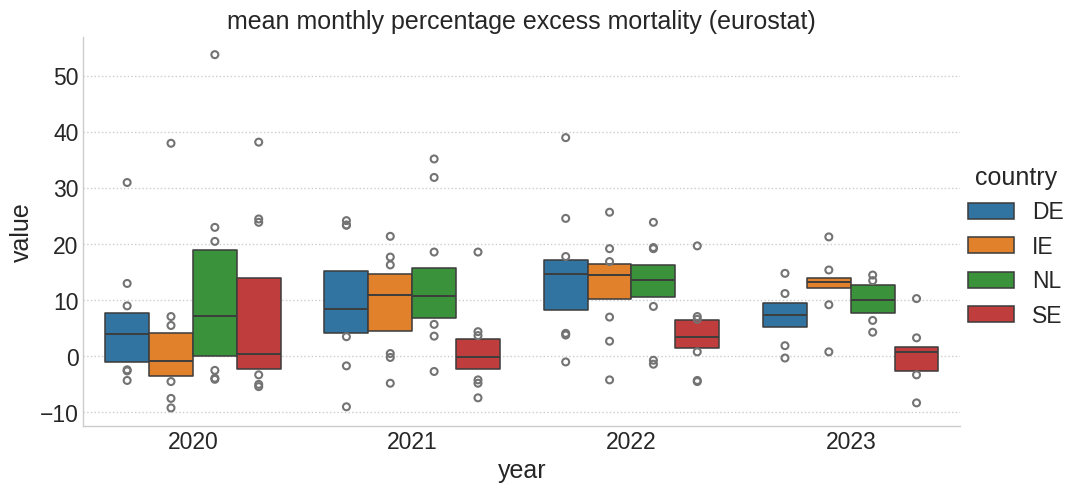

In [28]:
eu = pd.read_csv('eurostat_excess_bymonth.csv')
eu['date'] = pd.to_datetime(eu.month,format='%Y-%m')#,errors='ignore')
eu['year'] = eu.date.dt.year
p = pd.pivot_table(eu,index='date',columns='country',values='value')
p.plot(y=['IE','SE','DE'],figsize=(12,4))

sub = eu[eu.country.isin(['IE','DE','NL','SE'])]
sns.catplot(data=sub,x='year',y='value',hue='country',kind='boxen',aspect=2)
plt.title('mean monthly percentage excess mortality (eurostat)')

In [ ]:
x = df.groupby(['year','week']).size().reset_index()
x['time'] = x.apply(lambda x: '%s-W%02d' %(x.year,x.week),1)
x=x.set_index('time').iloc[:,2:]
x.columns=['RIP.ie']
#print (x[-20:])
x=x.merge(eu,left_index=True, right_index=True,how='right')
#x['diff'] = x.RIP-x.Eurostat
#print (x[-20:])
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
sns.despine()
plt.tight_layout()
plt.title('Weekly mortality RIP.ie estimate vs Eurostat',fontsize=25)
#ax2 = fig.add_axes( [0.4, 0.6, 0.15, 0.3])
#x.plot(x='Eurostat',y='RIP.ie',kind='scatter',c='black',ax=ax2)
plt.tight_layout()
fig.savefig('eurostat_ireland_deaths_compared.png')

## CSO RIP.ie

CSO's estimates can be accessed via their Pxstat system [here](https://data.cso.ie/product/MFPDA). See also https://www.cso.ie/en/releasesandpublications/in/vs/informationnoteonthepublicationofmortalityfiguresusingpublicdatasources/

In [19]:
cso=pd.read_csv('rip_cso_est.csv')
cso['date'] = pd.to_datetime(cso.Day)

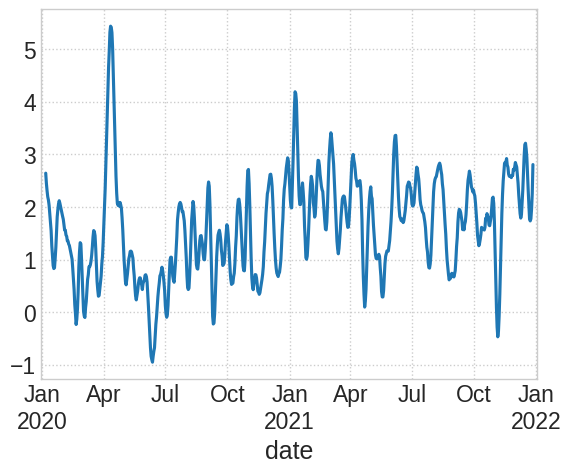

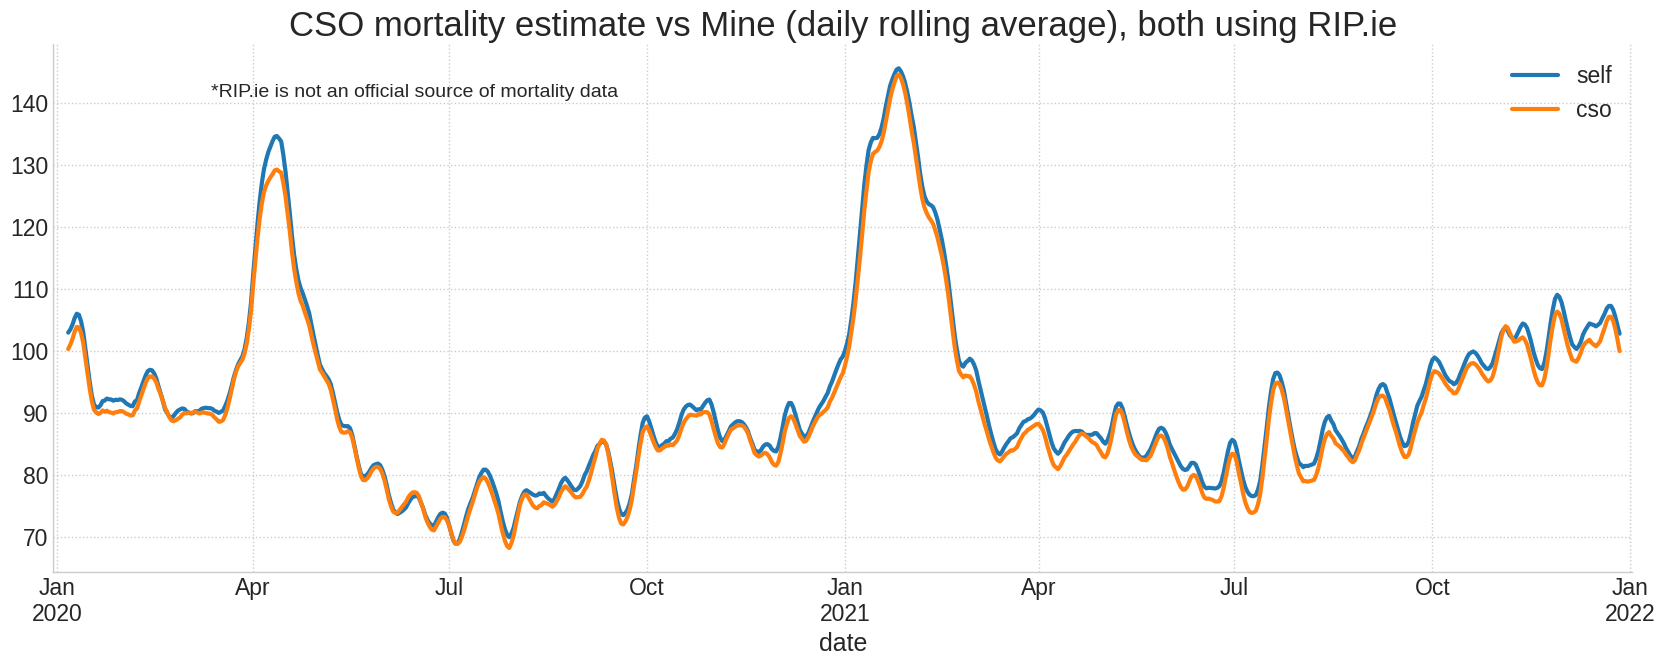

In [20]:
x = pd.DataFrame(df.groupby('date').size(),columns=['deaths']).reset_index()
x=x.merge(cso,on='date',how='right').set_index('date')
x=x[['deaths','VALUE']]
#(x.deaths-x.VALUE).rolling(window=win).mean().plot()
x.columns=['self','cso']
win=14
x=x.rolling(window=win,win_type='hamming',center=True).mean()
diff=x.self-x.cso
diff.plot()
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
plt.title('CSO mortality estimate vs Mine (daily rolling average), both using RIP.ie',fontsize=25)
plt.text(0.1,0.9,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
sns.despine()
plt.tight_layout()
fig.savefig('cso_ireland_deaths_compared.png')

In [ ]:
agep=pd.read_csv('EY002.20220127T230103.csv')
agep=agep[(agep.Sex=='Both sexes') &(agep['Age Group']!='All ages')]
agep['total']=agep.groupby('CensusYear')["VALUE"].transform('sum')
agep['ratio']=agep.VALUE/agep.total
agep

In [ ]:
x=df[(df.year==2020) & (df.month==4) & (df.home.notnull())]
x.home.value_counts()

## OWID excess deaths

In [ ]:
owid=pd.read_csv('excess-mortality-p-scores-average-baseline.csv')
owid['Date'] = pd.to_datetime(owid.Day)

In [ ]:
x = owid[owid.Entity.isin(['Ireland'])]#'United Kingdom','Italy'])]
x = x.merge(rdf,left_on='Date',right_on='date',how='left')
#sns.lineplot(data=x,x='Date',y='p_avg_all_ages',hue='Entity')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
x.plot(x='Date',y=['p_avg_all_ages','excess2'],ax=ax)
ax.legend(labels=['OWID excess','RIP.ie estimate'])
sns.despine()
#axs=x.groupby('Entity').plot(x='Date',y='p_avg_all_ages',subplots=True,layout=(3,1),sharey=True)

## vaccination data

In [ ]:
a = pd.read_csv('COVID-19_HSE_Daily_Vaccination_Figures.csv')
a['date'] = pd.to_datetime(a.VaccinationDate)
b =  pd.read_csv('COVID-19_HSE_Daily_Booster_Vaccination_Figures.csv')
b['date'] = pd.to_datetime(b.VaccinationDate)

In [36]:
v = a.merge(b,on='date',how='left')

In [38]:
sub = df[df.year>=2019]
x = sub.groupby('date').size()
x = x.rolling(21,win_type='hamming',center=True).mean().dropna()
yr=x.resample("Q").agg(["sum"]).reset_index()
x = pd.DataFrame(x,columns=['deaths'])#.reset_index()
#v= v.merge(x,on='date')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(23,6))
#v.plot(x='date',y=['Dose1','Dose2','AdditionalDose','AdditionalDose2'],ax=ax)
v.plot(x='date',y=['Dose1Cum','Dose2Cum','AdditionalDoseCum','AdditionalDoseCum2'],ax=ax)

ax1=ax.twinx()
#ax2=ax.twinx()
x.plot(c='purple',ax=ax1)
#yr.plot(x='date',marker='o',c='red',lw=1,ax=ax2)
ax.set_title('vaccine rollouts and total daily deaths')
sns.despine()